# Importing the required Libraries

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from scipy import stats

In [119]:
data_path = r"C:\Users\arnav\Downloads\delaney-processed.csv"
df = pd.read_csv(data_path)

print(df.head())

  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   
1           

We are converting the SMILES strings in the `'smiles'` column into RDKit molecule objects using `Chem.MolFromSmiles`, and storing these molecule objects in a new column called `'mol'`.


In [120]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

- Define a function `mol_to_fp` to convert an RDKit molecule into a Morgan fingerprint (circular fingerprint) with specified radius and bit length.
- Use RDKit’s `rdFingerprintGenerator.GetMorganGenerator` to generate the fingerprint.
- Convert the fingerprint into a NumPy array of integers representing the bit vector.
- Apply this function to all molecules in the `df['mol']` column to create an array of fingerprints.
- Assign this array to `X` as the feature matrix.
- Extract the target variable, measured solubility, into `y`.


In [121]:
def mol_to_fp(mol, radius=4, n_bits=4096):
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros((n_bits,), dtype=int)
    ConvertToNumpyArray(fp, arr)
    return arr

fingerprints = np.array([mol_to_fp(mol) for mol in df['mol']])
print(fingerprints.shape)

X = np.array(fingerprints)
y = df['measured log solubility in mols per litre'].values

(1128, 4096)


- Define `calculate_descriptors` function to compute key molecular descriptors for a given molecule:
  - **MW**: Molecular weight
  - **LogP**: Octanol-water partition coefficient (lipophilicity)
  - **NumHDonors**: Number of hydrogen bond donors
  - **NumHAcceptors**: Number of hydrogen bond acceptors
  - **TPSA**: Topological polar surface area
  - **NumRotatableBonds**: Number of rotatable bonds
  - **NumAromaticRings**: Number of aromatic rings
- Returns a dictionary mapping descriptor names to their values for the input molecule.


In [122]:
def calculate_descriptors(mol):
    return {
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol)
    }

# Exploratory Data Analysis

The first plot is the bit index vs the number of molecules there is an activated bit

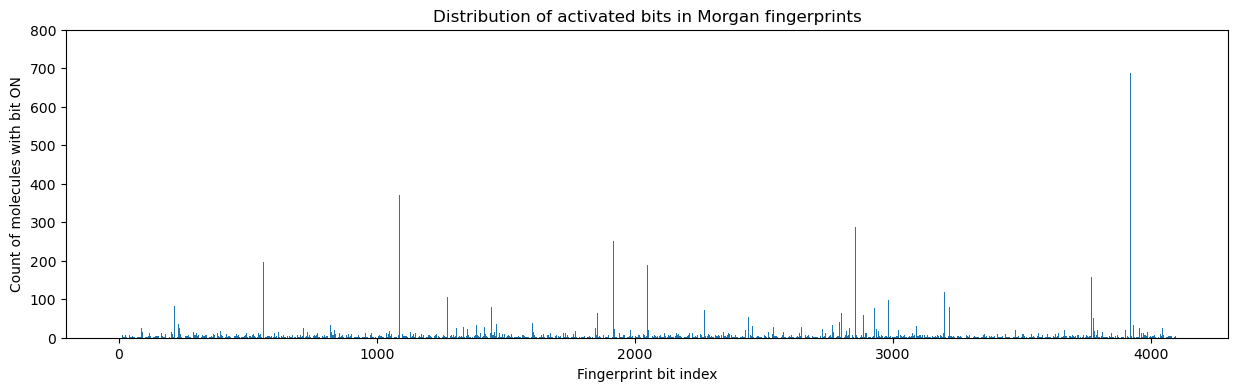

Average bits ON per fingerprint: 31.05
Min bits ON: 1
Max bits ON: 128


In [123]:
bit_counts = fingerprints.sum(axis=0)

plt.figure(figsize=(15,4))
plt.bar(range(len(bit_counts)), bit_counts)
plt.xlabel("Fingerprint bit index")
plt.ylabel("Count of molecules with bit ON")
plt.title("Distribution of activated bits in Morgan fingerprints")
plt.show()

print(f"Average bits ON per fingerprint: {fingerprints.sum(axis=1).mean():.2f}")
print(f"Min bits ON: {fingerprints.sum(axis=1).min()}")
print(f"Max bits ON: {fingerprints.sum(axis=1).max()}")


The next plot is the log solubility vs the frequency

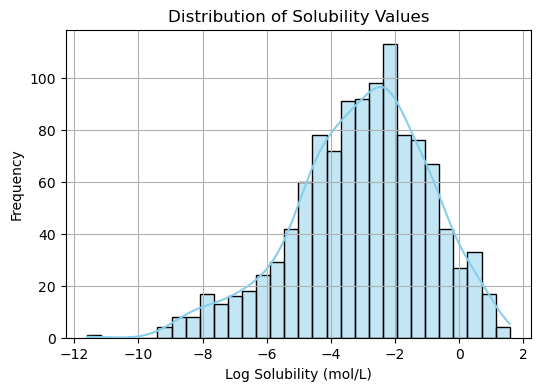

In [144]:
plt.figure(figsize=(6, 4))
sns.histplot(df['measured log solubility in mols per litre'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Solubility Values')
plt.xlabel('Log Solubility (mol/L)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The last plot is the PCA of the morgan freeprints

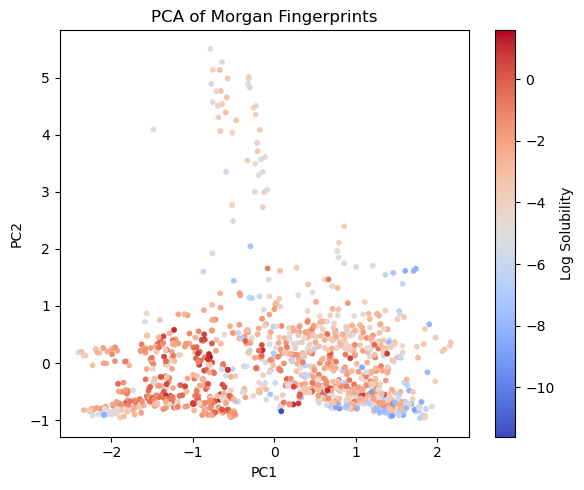

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_result = pca.fit_transform(fingerprints)

plt.figure(figsize=(6, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['measured log solubility in mols per litre'], cmap='coolwarm', s=10)
plt.colorbar(label='Log Solubility')
plt.title('PCA of Morgan Fingerprints')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


- **`mol_to_graph_features(mol)`**: Extracts 14 graph-related features from an RDKit molecule object. Returns a zero vector if molecule is `None`.

#### Features extracted:
1. **Basic graph properties**:
   - Number of atoms
   - Number of bonds
   - Number of heavy (non-hydrogen) atoms

2. **Ring structure**:
   - Total number of rings
   - Count of 6-membered rings (e.g., benzene)
   - Count of 5-membered rings (e.g., pyrrole)

3. **Atomic composition entropy**:
   - Shannon entropy of atom type distribution (diversity of atom types)

4. **Atomic degree statistics**:
   - Mean, standard deviation, and max of atomic degrees (number of bonded neighbors per atom)

5. **Hybridization variety**:
   - Number of unique hybridization states among atoms (e.g., sp, sp2, sp3)

6. **Charge profile**:
   - Sum of absolute formal charges
   - Standard deviation of charges

7. **Aromaticity**:
   - Fraction of atoms that are aromatic

- **`graph_features`**: Computed for all molecules using the function above.

- **`enhanced_features`**: Concatenates original Morgan fingerprints with these handcrafted graph features.



In [ ]:
def mol_to_graph_features(mol):
    if mol is None:
        return np.zeros(15)
    
    features = []
    
    features.append(mol.GetNumAtoms())
    features.append(mol.GetNumBonds())
    features.append(mol.GetNumHeavyAtoms())
    
    ring_info = mol.GetRingInfo()
    features.append(ring_info.NumRings())
    features.append(len([x for x in ring_info.AtomRings() if len(x) == 6])) 
    features.append(len([x for x in ring_info.AtomRings() if len(x) == 5]))  
    
    atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
    from collections import Counter
    counts = Counter(atom_types)
    total = sum(counts.values())
    entropy = -sum((count/total) * np.log2(count/total) for count in counts.values())
    features.append(entropy)
    
    degrees = [atom.GetDegree() for atom in mol.GetAtoms()]
    if degrees:
        features.extend([np.mean(degrees), np.std(degrees), np.max(degrees)])
    else:
        features.extend([0, 0, 0])
    
    hybrid_types = [str(atom.GetHybridization()) for atom in mol.GetAtoms()]
    hybrid_counts = Counter(hybrid_types)
    features.append(len(hybrid_counts)) 
    
    charges = [atom.GetFormalCharge() for atom in mol.GetAtoms()]
    features.extend([np.sum(np.abs(charges)), np.std(charges) if len(charges) > 1 else 0])
    
    aromatic_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic())
    features.append(aromatic_atoms / mol.GetNumAtoms() if mol.GetNumAtoms() > 0 else 0)
    
    return np.array(features)

graph_features = np.array([mol_to_graph_features(mol) for mol in df['mol']])

enhanced_features = np.hstack([fingerprints, graph_features])


print(f"Graph features: {graph_features.shape[1]} features")

Graph features: 14 features


### Feature Matrix & Train-Test Split

- `X_basic`: Morgan fingerprints only (structural features).
- `X_enhanced`: Morgan fingerprints + handcrafted graph-based features.
- `y`: Target variable — measured log solubility.

- Split both feature sets into training and testing (75/25) using the same random state for reproducibility.


In [125]:
X_basic = fingerprints  
X_enhanced = enhanced_features 
y = df['measured log solubility in mols per litre'].values

X_basic_train, X_basic_test, y_train, y_test = train_test_split(
    X_basic, y, test_size=0.25, random_state=42
)

X_enhanced_train, X_enhanced_test, _, _ = train_test_split(
    X_enhanced, y, test_size=0.25, random_state=42
)


### Model Evaluation Function

This function trains a given regression model and computes key performance metrics:

- **Inputs:**
  - `model`: The regression model (e.g., RandomForest, XGBoost)
  - `X_train`, `X_test`: Feature sets for training and testing
  - `y_train`, `y_test`: Target values
  - `model_name`: Label for the model

- **Outputs:**
  - A dictionary of metrics:  
    - RMSE (Root Mean Squared Error)
    - R² (Coefficient of Determination)
    - MAE (Mean Absolute Error)  
    — for both training and testing data.
  - Also returns predicted values on the test set (`y_test_pred`)


In [126]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
    }
    
    return results, y_test_pred


### Model Setup for Evaluation

We prepare a list of regression models to evaluate both **basic** (using Morgan fingerprints) and **enhanced** (fingerprints + graph features) features:

- **Random Forest (Basic)**  
- **XGBoost (Basic)**  
- **Random Forest (Enhanced)**  
- **XGBoost (Enhanced)**  

Each model is initialized with:
- `n_estimators=100`: Number of trees (for ensemble models)
- `random_state=42`: Ensures reproducibility
- `n_jobs=-1`: Uses all available CPU cores for faster training

The `models_to_test` list stores tuples of each model and its name.  
We also initialize:
- `all_results`: To store evaluation metrics  
- `all_predictions`: To store predicted values for future analysis


In [127]:
models_to_test = [
    (RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), "Random Forest (Basic)"),
    (xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), "XGBoost (Basic)"),
    (RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), "Random Forest (Enhanced)"),
    (xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), "XGBoost (Enhanced)")
]

all_results = []
all_predictions = []


### Evaluating Basic Models (Random Forest & XGBoost)

We iterate over the first two models in our `models_to_test` list i.e **Random Forest (Basic)** and **XGBoost (Basic)** and evaluate them using the **basic fingerprint features**.

For each model:
- We call `evaluate_model()` with the training and test sets.
- The function returns performance metrics and predictions.
- Results are stored in `all_results`, and predictions in `all_predictions`.

This step helps us assess how well the basic feature set captures solubility behavior.


In [128]:
for i, (model, name) in enumerate(models_to_test[:2]):
    results, predictions = evaluate_model(model, X_basic_train, X_basic_test, y_train, y_test, name)
    all_results.append(results)
    all_predictions.append(predictions)

## Plotting the results

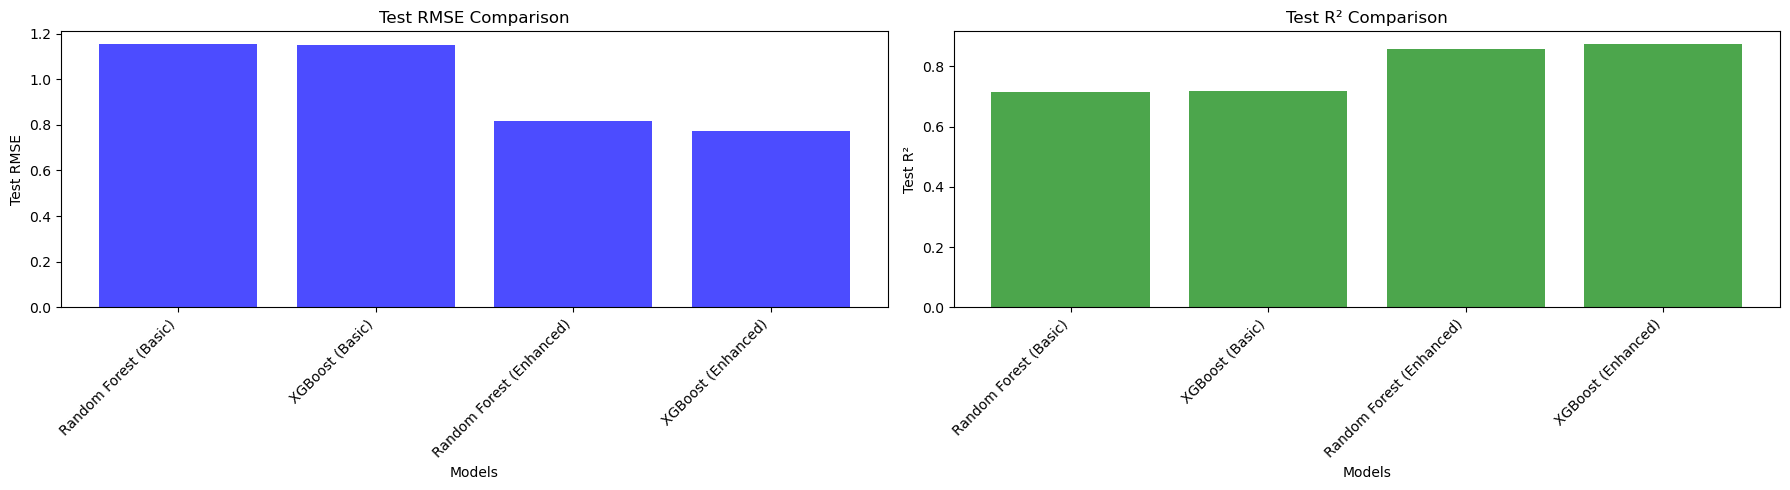

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) 

model_names = [r['Model'] for r in all_results]
test_rmse = [r['Test_RMSE'] for r in all_results]
test_r2 = [r['Test_R2'] for r in all_results]

axes[0].bar(range(len(model_names)), test_rmse, color='blue', alpha=0.7)
axes[0].set_title('Test RMSE Comparison')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Test RMSE')
axes[0].set_xticks(range(len(model_names)))
axes[0].set_xticklabels(model_names, rotation=45, ha='right')

# Test R²
axes[1].bar(range(len(model_names)), test_r2, color='green', alpha=0.7)
axes[1].set_title('Test R² Comparison')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Test R²')
axes[1].set_xticks(range(len(model_names)))
axes[1].set_xticklabels(model_names, rotation=45, ha='right')


plt.tight_layout()
plt.show()

let us see the model performace summary now. The results are also discussed in the report

In [132]:
print("Model Performance Summary:\n")

for result in all_results:
    print(f"Model: {result['Model']}")
    print(f"  Test RMSE : {result['Test_RMSE']:.4f}")
    print(f"  Test R²   : {result['Test_R2']:.4f}")
    print(f"  Test MAE  : {result['Test_MAE']:.4f}")
    print(f" ")


print("\nKEY INSIGHTS:")
print(f"Dataset size: {len(df)} molecules")

improvement = (all_results[-1]['Test_R2'] - all_results[1]['Test_R2']) * 100
print(f"Feature enhancement improved performance by {improvement:.1f}%")

print(f"Morgan fingerprints capture {all_results[1]['Test_R2']:.1%} of solubility variance")
print(f"Enhanced features capture {all_results[-1]['Test_R2']:.1%} of solubility variance")



Model Performance Summary:

Model: Random Forest (Basic)
  Test RMSE : 1.1520
  Test R²   : 0.7159
  Test MAE  : 0.8547
 
Model: XGBoost (Basic)
  Test RMSE : 1.1503
  Test R²   : 0.7167
  Test MAE  : 0.8627
 
Model: Random Forest (Enhanced)
  Test RMSE : 0.8185
  Test R²   : 0.8566
  Test MAE  : 0.5671
 
Model: XGBoost (Enhanced)
  Test RMSE : 0.7731
  Test R²   : 0.8720
  Test MAE  : 0.5482
 

KEY INSIGHTS:
Dataset size: 1128 molecules
Feature enhancement improved performance by 15.5%
Morgan fingerprints capture 71.7% of solubility variance
Enhanced features capture 87.2% of solubility variance


### GNN Model Architecture: `GNNNet` using GATConv

We define a Graph Neural Network using the **Graph Attention Network (GATConv)** layers from PyTorch Geometric to predict molecular solubility:

#### Layers & Components:
- **GATConv layers (3 total):** 
  Each applies multi-head self-attention to learn important interactions between molecular atoms (nodes).
- **BatchNorm:** 
  Added after each GATConv layer for normalization and stabilizing training.
- **Dropout (0.3):** 
  Regularization layer to prevent overfitting after the graph-level pooling.
- **global_add_pool:** 
  Aggregates node-level features to a graph-level representation.
- **Fully Connected Layers:** 
  A linear → ReLU → linear stack reduces the graph representation to a single output (solubility value).

#### Forward Pass:
1. Node features are passed through three GATConv layers with batch norm and ReLU activation.
2. Global graph representation is computed using `global_add_pool`.
3. A dropout layer is applied for regularization.
4. The final dense layers map the pooled features to a single solubility prediction.

This GAT-based GNN learns both local atomic environments and global molecular structure, enabling improved performance on graph-based chemical prediction tasks.


In [136]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GATConv, global_add_pool, BatchNorm

class GNNNet(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=128):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=4, concat=False)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=4, concat=False)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=4, concat=False)
        self.bn3 = BatchNorm(hidden_dim)

        self.dropout = Dropout(0.3)
        self.lin1 = Linear(hidden_dim, hidden_dim // 2)
        self.lin2 = Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = global_add_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

### Model Training Setup: Optimizer, Scheduler, and Loss

We set up the training pipeline for the GNN model using optimized configurations:

#### Optimizer: `AdamW`
- **AdamW** is used instead of vanilla Adam for better weight decay regularization.
- `lr=0.001`: Initial learning rate.
- `weight_decay=1e-4`: Prevents overfitting by penalizing large weights.

#### Learning Rate Scheduler: `ReduceLROnPlateau`
- Monitors the **validation loss**.
- **Reduces** the learning rate by a factor of `0.7` if no improvement is seen for `10` epochs.
- Helps avoid getting stuck in flat local minima.

#### Loss Function: `MSELoss`
- **Mean Squared Error (MSE)** is used since we are solving a **regression problem** (predicting solubility).



In [137]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = GNNNet(num_features=train_data[0].x.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10)
criterion = torch.nn.MSELoss()

### Training and Evaluation Functions

#### `train(model, loader, optimizer, criterion)`
- Sets the model to training mode.
- Iterates through each batch in the `loader`:
  - Moves data to the appropriate device (CPU/GPU).
  - Clears gradients using `optimizer.zero_grad()`.
  - Passes node features and edge information to the model.
  - Computes the loss between predictions and true labels.
  - Backpropagates the loss and updates model weights.
  - Accumulates the total loss across all graphs.
- Returns the average loss per graph for the epoch.

#### `test(model, loader)`
- Disables gradient computation using `@torch.no_grad()` and sets model to evaluation mode.
- Iterates through the data:
  - Collects predictions and true values for each graph.
- Returns predicted and true values as NumPy arrays for further metric calculation (RMSE, R², etc.).


In [139]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch).squeeze()
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def test(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch).squeeze()
        y_true.append(data.y.cpu())
        y_pred.append(out.cpu())
    return torch.cat(y_true).numpy(), torch.cat(y_pred).numpy()

In [140]:
train_val_data, test_data = train_test_split(graph_data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)


In [141]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


### We train the GNN model for 200 epochs and print the results every 10 epochs

In [142]:
for epoch in range(1, 201):
    loss = train(model, train_loader, optimizer, criterion)
    
    y_val, y_pred_val = test(model, val_loader)
    val_loss = criterion(torch.tensor(y_pred_val), torch.tensor(y_val)).item()
    
    scheduler.step(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch  10 | Train Loss: 0.2987 | Val Loss: 0.1969
Epoch  20 | Train Loss: 0.2066 | Val Loss: 0.1408
Epoch  30 | Train Loss: 0.1743 | Val Loss: 0.1394
Epoch  40 | Train Loss: 0.1489 | Val Loss: 0.1198
Epoch  50 | Train Loss: 0.1020 | Val Loss: 0.1161
Epoch  60 | Train Loss: 0.0991 | Val Loss: 0.1117
Epoch  70 | Train Loss: 0.1138 | Val Loss: 0.1366
Epoch  80 | Train Loss: 0.0791 | Val Loss: 0.1133
Epoch  90 | Train Loss: 0.0731 | Val Loss: 0.1011
Epoch 100 | Train Loss: 0.0703 | Val Loss: 0.1017
Epoch 110 | Train Loss: 0.0847 | Val Loss: 0.1068
Epoch 120 | Train Loss: 0.0645 | Val Loss: 0.1016
Epoch 130 | Train Loss: 0.0684 | Val Loss: 0.1008
Epoch 140 | Train Loss: 0.0595 | Val Loss: 0.0984
Epoch 150 | Train Loss: 0.0653 | Val Loss: 0.0958
Epoch 160 | Train Loss: 0.0530 | Val Loss: 0.0980
Epoch 170 | Train Loss: 0.0535 | Val Loss: 0.0975
Epoch 180 | Train Loss: 0.0510 | Val Loss: 0.0970
Epoch 190 | Train Loss: 0.0525 | Val Loss: 0.0970
Epoch 200 | Train Loss: 0.0501 | Val Loss: 0.0973


### Final summary of the GNN. We see that GNN provides a better R2 metric than the classical ML models

In [143]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 
r2 = r2_score(y_true, y_pred)

print(f"RMSE     : {rmse:.4f}")
print(f"R² Score : {r2:.4f}")


RMSE     : 0.6883
R² Score : 0.8998
